**Group Members:** Raunak Shah, Varun Goyal, Ishanh Misra \\
**Project Mode:** Mixed \\
**Topic:** ADMM

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(70) #for reproducibility

### Initializations for QP - ADMM

Original Problem: 

$min_{u} \;\frac{1}{2}u^TQu+q^Tu \;$ s.t. $Au\leq b$

**IMPORTANT:** 
If you want to run just ADMM to replicate Fig. 1 and 2 of the term paper, set Nu=500 and Nb=250 and run ONLY the ADMM cells (AMA will take too long). \\
If you want to run AMA and compare it with ADMM to replicate Fig. 3 of the term paper, set Nu=50 and Nb=25 and run all the cells.

In [ ]:
Nu = 500
Nb = 250
tau = 1
A = np.random.normal(0, 1, (Nb, Nu))

In [ ]:
Q_temp = np.random.normal(0, 1, (Nu, Nu))
Q = np.dot(Q_temp.T, Q_temp) # Q is psd

In [ ]:
q = np.random.normal(0, 1, Nu)
b = np.random.normal(0, 1, Nb)

v_init = np.random.normal(0, 1, Nb)
lambd_init = np.random.rand(Nb)

### Standard ADMM

In [ ]:
v = v_init
lambd = lambd_init
primal_res = []
dual_res = []
iters = np.arange(0, 500)

cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd+tau*v) - q) # u-update
    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd/tau), b) # v-update
    lambd = lambd + tau*(v - np.dot(A, u)) # lambda-update

    primal_res.append(np.linalg.norm(v - np.dot(A, u), 2))
    dual_res.append(np.linalg.norm(-tau*np.matmul(A.T, v - v_prev), 2))

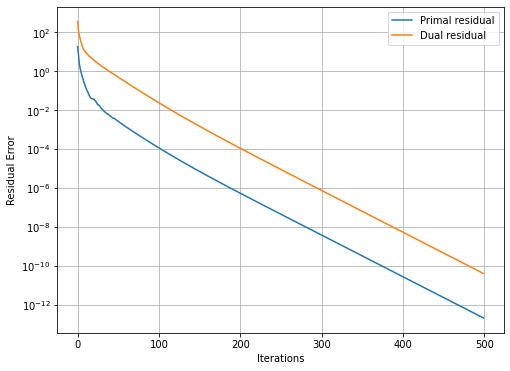

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(primal_res, label="Primal residual")
plt.plot(dual_res, label="Dual residual")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual Error")
plt.legend()
plt.grid()

### FISTA-Accelerated ADMM for Strongly Convex H and G

Note that here $G(v) = I_{v\leq b}$ is NOT strongly convex (proved in the term paper), so this algorithm should not converge as per the theory. We still implemented it, and that is what we observed below:

In [ ]:
v = v_init
v_hat = v_init
lambd = lambd_init
lambd_hat = lambd_init
alpha = 1

primal_res_acc = []
dual_res_acc = []
iters = np.arange(0, 500)

cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd_hat+tau*v_hat) - q)

    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd_hat/tau), b)

    lambd_prev = lambd
    lambd = lambd_hat + tau*(v - np.dot(A, u))

    alpha_prev = alpha
    alpha = (1+np.sqrt(1+4*(alpha**2)))/2

    v_hat = v + (alpha_prev-1)*(v - v_prev)/alpha
    lambd_hat = lambd + (alpha_prev-1)*(lambd-lambd_prev)/alpha

    primal_res_acc.append(np.linalg.norm(v - np.dot(A, u), 2))
    dual_res_acc.append(np.linalg.norm(-tau*np.matmul(A.T, v - v_prev), 2))

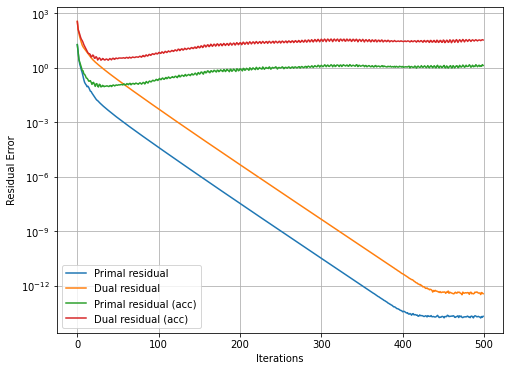

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(iters, primal_res, label="Primal residual")
plt.plot(iters, dual_res, label="Dual residual")
plt.plot(iters, primal_res_acc, label="Primal residual (acc)")
plt.plot(iters, dual_res_acc, label="Dual residual (acc)")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual Error")
plt.legend()
plt.grid()

### FISTA-Accelerated ADMM with Restart Method

In [ ]:
v = v_init
v_hat = v_init
lambd = lambd_init
lambd_hat = lambd_init
alpha = 1
c = 0

primal_res_accr = []
dual_res_accr = []
iters = np.arange(0, 500)

cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

eta = 0.999
for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd_hat+tau*v_hat) - q)

    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd_hat/tau), b)

    lambd_prev = lambd
    lambd = lambd_hat + tau*(v - np.dot(A, u))

    c_prev = c
    c = (np.linalg.norm(lambd - lambd_hat, 2)**2)/tau + tau*(np.linalg.norm(v - v_hat, 2)**2)
    
    alpha_prev = alpha
    if c < eta*c_prev:
        alpha = (1+np.sqrt(1+4*(alpha**2)))/2

        v_hat = v + (alpha_prev-1)*(v - v_prev)/alpha
        lambd_hat = lambd + (alpha_prev-1)*(lambd-lambd_prev)/alpha 
    else:
        alpha = 1
        v_hat = v_prev
        lambd_hat = lambd_prev
        c = c/eta

    primal_res_accr.append(np.linalg.norm(v - np.dot(A, u), 2))
    dual_residual = np.linalg.norm(-tau*np.matmul(A.T, v - v_prev), 2)
    if dual_residual == 0:
        dual_res_accr.append(dual_res_accr[-1])
    else:
        dual_res_accr.append(dual_residual)

lambd_opt = lambd # This is the final optimal lambda. We use this to help track the error for AMA below.

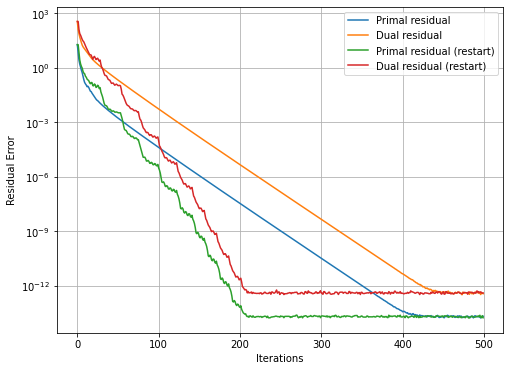

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(iters, primal_res, label="Primal residual")
plt.plot(iters, dual_res, label="Dual residual")
plt.plot(iters, primal_res_accr, label="Primal residual (restart)")
plt.plot(iters, dual_res_accr, label="Dual residual (restart)")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual Error")
plt.legend()
plt.grid()

Note that in the ADMM experiments above, convergence is faster when Nu=50 and Nb=25 compared to Nu=500 and Nb=250. This is expected since the dimensionality of the problem is smaller in the first case. The effectiveness of the restart method is more clearly observed in the problem with higher dimensionality.

### Sensitivity of convergence of ADMM to the value of $\tau$


In [ ]:
# Normal ADMM
tau = 1
taus = []
tau_sens = []
for tau in np.logspace(-2, 2, 26):
    v = v_init
    lambd = lambd_init
    iters = np.arange(0, 10000)
    cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

    for k in iters:
        u = np.matmul(cached_inv, np.dot(A.T, lambd+tau*v) - q)
        v_prev = v
        v = np.minimum(np.dot(A, u) - (lambd/tau), b)
        lambd = lambd + tau*(v - np.dot(A, u))

        primal_residual = np.linalg.norm(v - np.dot(A, u), 2)
        dual_residual = np.linalg.norm(-tau*np.matmul(A.T, v - v_prev), 2)

        if primal_residual < 10**(-5) and dual_residual < 10**(-5):
            taus.append(tau)
            tau_sens.append(k)
            break

In [ ]:
# Accelerated ADMM + Restart Method
tau = 1
taus_acc = []
tau_sens_acc = []
for tau in np.logspace(-2, 2, 26):
    v = v_init
    v_hat = v_init
    lambd = lambd_init
    lambd_hat = lambd_init
    alpha = 1

    iters = np.arange(0, 10000)
    cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

    eta = 0.999
    for k in iters:
        u = np.matmul(cached_inv, np.dot(A.T, lambd_hat+tau*v_hat) - q)

        v_prev = v
        v = np.minimum(np.dot(A, u) - (lambd_hat/tau), b)

        lambd_prev = lambd
        lambd = lambd_hat + tau*(v - np.dot(A, u))

        c_prev = c
        c = (np.linalg.norm(lambd - lambd_hat, 2)**2)/tau + tau*(np.linalg.norm(v - v_hat, 2)**2)
        
        alpha_prev = alpha
        if c < eta*c_prev:
            alpha = (1+np.sqrt(1+4*(alpha**2)))/2

            v_hat = v + (alpha_prev-1)*(v - v_prev)/alpha
            lambd_hat = lambd + (alpha_prev-1)*(lambd-lambd_prev)/alpha 
        else:
            alpha = 1
            v_hat = v_prev
            lambd_hat = lambd_prev
            c = c/eta

        primal_residual = np.linalg.norm(v - np.dot(A, u), 2)
        dual_residual = np.linalg.norm(-tau*np.matmul(A.T, v - v_prev), 2)

        if primal_residual < 10**(-5) and dual_residual < 10**(-5):
            taus_acc.append(tau)
            tau_sens_acc.append(k)
            break

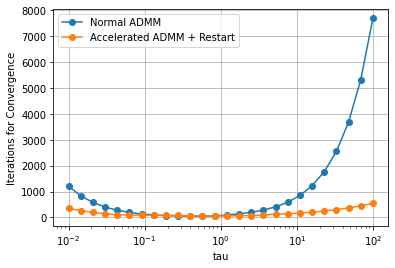

In [ ]:
plt.plot(taus, tau_sens, 'o-', label='Normal ADMM')
plt.plot(taus_acc, tau_sens_acc, 'o-', label='Accelerated ADMM + Restart')
plt.xscale("log")
plt.grid()
plt.ylabel("Iterations for Convergence")
plt.xlabel("tau")
plt.legend()

### Normal AMA

**IMPORTANT**: If you want to run AMA, set Nu=50 and Nb=25 above and run all the cells again

In [ ]:
def dual_objective(lamb):
    """Computes the dual objective D(lambda)"""
    temp = np.dot(A.T, lamb)-q
    return -0.5*np.matmul(temp.T, np.matmul(np.linalg.inv(Q), temp))+np.dot(b, lamb)

In [ ]:
v = v_init
lambd = lambd_init
ama_primal_res = []
ama_dual_res = []

iters = np.arange(0, 5000)
tau = np.min(np.linalg.eigvalsh(Q))/np.max(np.abs(np.linalg.eigvalsh(np.matmul(A.T, A))))

cached_inv = np.linalg.inv(Q)
for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd) - q)

    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd/tau), b)

    lambd_prev = lambd
    lambd = lambd + tau*(v - np.dot(A, u))
    
    ama_primal_res.append(np.linalg.norm(v - np.dot(A, u), 2))
    ama_dual_res.append(dual_objective(lambd_opt) - dual_objective(lambd))

### Fast AMA for strongly convex H and convex G

In [ ]:
v = v_init
v_hat = v_init
lambd = lambd_init
lambd_hat = lambd_init
alpha = 1
fast_ama_primal_res = []
fast_ama_dual_res = []

iters = np.arange(0, 5000)

cached_inv = np.linalg.inv(Q)
for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd_hat) - q)

    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd_hat/tau), b)

    lambd_prev = lambd
    lambd = lambd_hat + tau*(v - np.dot(A, u))

    alpha_prev = alpha
    alpha = (1+np.sqrt(1+4*(alpha**2)))/2

    lambd_hat = lambd + (alpha_prev-1)*(lambd-lambd_prev)/alpha 

    fast_ama_primal_res.append(np.linalg.norm(v - np.dot(A, u), 2))
    fast_ama_dual_res.append(dual_objective(lambd_opt) - dual_objective(lambd))

### AMA with Restart

In [ ]:
v = v_init
v_hat = v_init
lambd = lambd_init
lambd_hat = lambd_init
alpha = 1

ama_primal_res_accr = []
ama_dual_res_accr = []
iters = np.arange(0, 5000)

cached_inv = np.linalg.inv(Q)

for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd_hat) - q)

    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd_hat/tau), b)

    lambd_prev = lambd
    lambd = lambd_hat + tau*(v - np.dot(A, u))
   
    alpha_prev = alpha
    if dual_objective(lambd) >= dual_objective(lambd_prev):
        alpha = (1+np.sqrt(1+4*(alpha**2)))/2
        lambd_hat = lambd + (alpha_prev-1)*(lambd-lambd_prev)/alpha
    else:
        alpha = 1
        lambd_hat = lambd_prev

    ama_primal_res_accr.append(np.linalg.norm(v - np.dot(A, u), 2))
    ama_dual_res_accr.append(dual_objective(lambd_opt) - dual_objective(lambd))

### Comparison with Normal ADMM

In [ ]:
v = v_init
lambd = lambd_init
admm_primal_res = []
admm_dual_res = []
tau = 1
iters = np.arange(0, 5000)

cached_inv = np.linalg.inv((Q + tau*np.matmul(A.T, A)))

for k in iters:
    u = np.matmul(cached_inv, np.dot(A.T, lambd+tau*v) - q)
    v_prev = v
    v = np.minimum(np.dot(A, u) - (lambd/tau), b)
    lambd = lambd + tau*(v - np.dot(A, u))

    admm_primal_res.append(np.linalg.norm(v - np.dot(A, u), 2))
    admm_dual_res.append(abs(dual_objective(lambd_opt) - dual_objective(lambd)))

### AMA: Plots

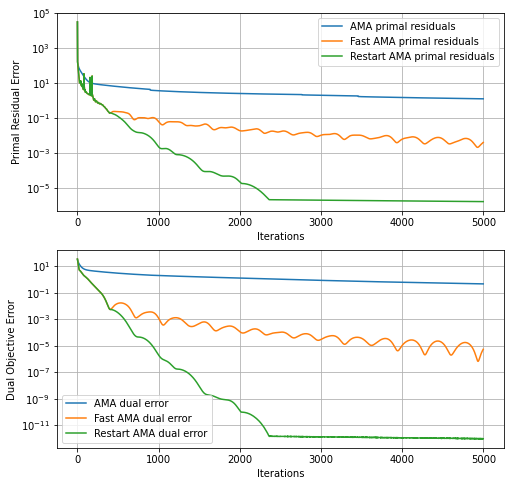

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(iters, ama_primal_res, label="AMA primal residuals")
plt.plot(iters, fast_ama_primal_res, label="Fast AMA primal residuals")
plt.plot(iters, ama_primal_res_accr, label="Restart AMA primal residuals")

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Primal Residual Error")
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(iters, ama_dual_res, label="AMA dual error")
plt.plot(iters, fast_ama_dual_res, label="Fast AMA dual error")
plt.plot(iters, ama_dual_res_accr, label="Restart AMA dual error")

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Dual Objective Error")
plt.legend()
plt.grid()

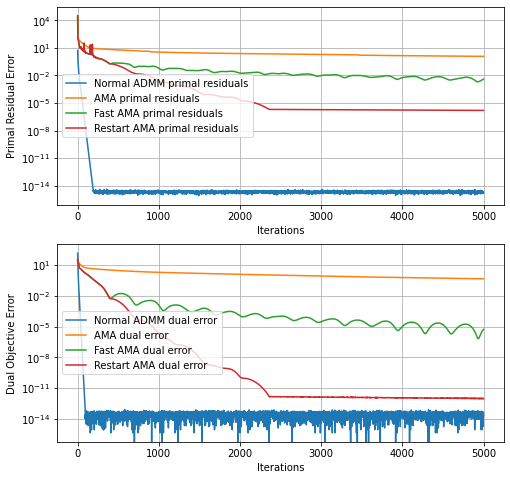

In [ ]:
# This plot shows how normal ADMM performs in comparison to the AMA variants. 
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(iters, admm_primal_res, label="Normal ADMM primal residuals") 
plt.plot(iters, ama_primal_res, label="AMA primal residuals")
plt.plot(iters, fast_ama_primal_res, label="Fast AMA primal residuals")
plt.plot(iters, ama_primal_res_accr, label="Restart AMA primal residuals")

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Primal Residual Error")
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(iters, admm_dual_res, label="Normal ADMM dual error")
plt.plot(iters, ama_dual_res, label="AMA dual error")
plt.plot(iters, fast_ama_dual_res, label="Fast AMA dual error")
plt.plot(iters, ama_dual_res_accr, label="Restart AMA dual error")

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Dual Objective Error")
plt.legend()
plt.grid()